### This is where I build my dataset. It will be splitted after on the train cell

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from utils.generate import GenerateDataset
import torch

dataset = GenerateDataset()
dataset.processingData(num_date=10,
                    type ='Train',
                    running_instance = 'test_pre',
                    generate =True, 
                    validation_fraction=0.2
                    )


train_path = dataset.getTrainPath()
val_path = dataset.getValPath()


/Users/guillaumeberthelot/anaconda3/envs/SDD_Torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


./data/OSSE_U_V_SLA_SST_2015_TEST_for_FORECAST.nc
./data/eddies_TRAIN_for_FORECAST.nc
./data/OSSE_U_V_SLA_SST_2015_TRAIN_for_FORECAST.nc
dataset already logged in .gitignore
train
****************************************************************************************************
Dataset has been initialised, inputs shape torch.Size([186, 10, 384, 768]), 186 elements of depth 10.
Use generateAndSplit to generate and save TRAIN and VAL
Target shape is a tensor of depth 30
****************************************************************************************************
dataset/test_pre already logged in .gitignore
****************************************************************************************************
train_dataset has been created, inputs shape, 149 elements.
recorded at dataset/test_pre/TrainDataset_test_pre__dataset.pt
train_dataset has been created, inputs shape, 37 elements.
recorded at dataset/test_pre/ValDataset_test_pre__dataset.pt
nan_mask_label_deconv has been cr

AttributeError: 'function' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [3]:

nan_path = dataset.getNanMaskLabelPath()
nan_deconv_path = dataset.getNanMaskLabelDeconvPath()
train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
nan_masked_label = torch.load(nan_path)
nan_masked_label_deconv = torch.load(nan_deconv_path)





In [2]:
import sys
sys.getsizeof(dataset)

NameError: name 'dataset' is not defined

'dataset/test_pre/TrainDataset_test_pre__dataset.pt'

This cell below is useful to create the mask for the back_resize to the original shape of pictures

### Train parameters and calling
You should load Uned before and check the commented lines, you can start from  or download a pretrained net.

In [5]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from CNN.unet import UNet
from utils.train import TrainDataset
from utils.generate import GenerateDataset
from utils.device import self_device
import torch.nn as nn

device = self_device()
print(f'GPU device type = {device}')
print(device)



GPU device type = mps
mps


In [6]:


model_list=[]
num_epochs =100
learning_rate=0.01
batch_size = 3




model = UNet(n_class=3,num_dates = 10, verbose=False)


#_,nan_mask_label_deconv, nan_mask_label = GenerateDataset().processingData(num_date=10)
#weights_path = 'UNet_trained/UNet_Train_1_Epoch_98_valacc_91.76040649414062.pth'
#model.load_state_dict(torch.load(weights_path))
#train_dataset = torch.load('DATASET_test_pre/TrainDataset_test_pre__dataset.pt')
#val_dataset = torch.load('DATASET_test_pre/ValDatasettest_pre__dataset.pt')
model.to(device)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.MSELoss()
running_instance = 'test_pre'

TD = TrainDataset(model=model,
                  criterion=criterion,  
                  optimizer=optimizer,
                  scheduler=scheduler,
                  num_epochs=num_epochs,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  device=device,
                  nan_mask_label=nan_masked_label[:batch_size,:,:,:],
                  running_instance=running_instance,
                  num_dates=10)


model = TD.train_model(train_dataset,val_dataset)

----------------------------------------------------------------------------------------------------
Epoch 0/100
----------------------------------------------------------------------------------------------------
batch_loss 1_Epoch_0=0.20, accuracy = 31.69%
batch_loss 10_Epoch_0=0.13, accuracy = 76.32%
batch_loss 20_Epoch_0=0.12, accuracy = 77.75%
batch_loss 30_Epoch_0=0.12, accuracy = 76.40%
batch_loss 40_Epoch_0=0.12, accuracy = 76.30%


KeyboardInterrupt: 

In [91]:

""" 
This is the code to save the prediction to a csv file 
"""
import csv
output_file = 'predictioncomplete_999.csv'
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for d in range(10):
        for m in range(4):
            data = array_list_following[m][d]
            for y, row in enumerate(data):
                for x, value in enumerate(row):
                    day=m*7+d
                    id = f"{day}_{y}_{x}"
                    value = np.int32(value)
                    writer.writerow({'Id': id, 'Predicted': value})
 

In [9]:
""" This part of the code is needed to load the validation dataset and get the input and labels"""
from torch.utils.data import DataLoader
val_dataset = torch.load(val_path)

val_loader = DataLoader(dataset = val_dataset, batch_size=len(val_dataset),shuffle=False, drop_last=False)
for input, labels in val_loader:
    break


In [20]:
""" This is the code to load the trained model and the weights and to make the prediction. 
The prediction is then reshaped to the original shape of the image.
The prediction is then converted to a one hot encoding and then to a label.
The label is then reshaped to the original shape of the image.
The label and the prediction are then saved to a list.
    """

from torchvision import transforms
list_following_predicted = []
list_following_ground_truth=[]
model = UNet(n_class=3,num_dates = 10, verbose=False)
weights_path = 'UNet_trained/UNet_Train_1_Epoch_98_valacc_91.76040649414062.pth'
model.load_state_dict(torch.load(weights_path))
model.to('cpu')
model.eval()

for i in range(len(input)):    
    item= input[i].unsqueeze(0)
    label = labels[i].unsqueeze(0)
    item =model(item)
    trans_back = transforms.Resize((357,717))
    item = trans_back(item)
    label = trans_back(label)
   
    reshaped_output = item.view(item.size(0), 3, 10, item.size(2), item.size(3))
    max_indices = torch.argmax(reshaped_output, dim=1)
    one_hot_encoding = torch.zeros_like(reshaped_output)
    item = one_hot_encoding.scatter_(1, max_indices.unsqueeze(1), 1)



    item =0*item[:,0,:,:,:]+1*item[:,1,:,:,:]+2*item[:,2,:,:,:]

    item = torch.where(nan_masked_label_deconv[0,:,:,:],torch.tensor(999),item)



    reshaped_label = label.view(label.size(0), 3, 10, label.size(2), label.size(3))
    max_indices_label = torch.argmax(reshaped_label, dim=1)
    one_hot_encoding_label = torch.zeros_like(reshaped_label)
    label= one_hot_encoding_label.scatter_(1, max_indices_label.unsqueeze(1), 1)

    label=0*label[:,0,:,:,:]+1*label[:,1,:,:,:]+2*label[:,2,:,:,:]

    label = torch.where(nan_masked_label_deconv[0,:,:,:],torch.tensor(999),label)
    label=label.squeeze(0)
    print(label.shape)
    label_final = label[:,:,:].detach().numpy()
    print(label_final.shape)
    list_following_ground_truth.append(label_final)

    item=item.squeeze(0)
    print(item.shape)
    item_final = item[:,:,:].detach().numpy()
    print(item_final.shape)
    list_following_predicted.append(item_final)

torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 35

### Eddies animation 

<div class ='alert alert-success'>

The two next following cells are for creating video animation of prediction vs ground Truth
</div>

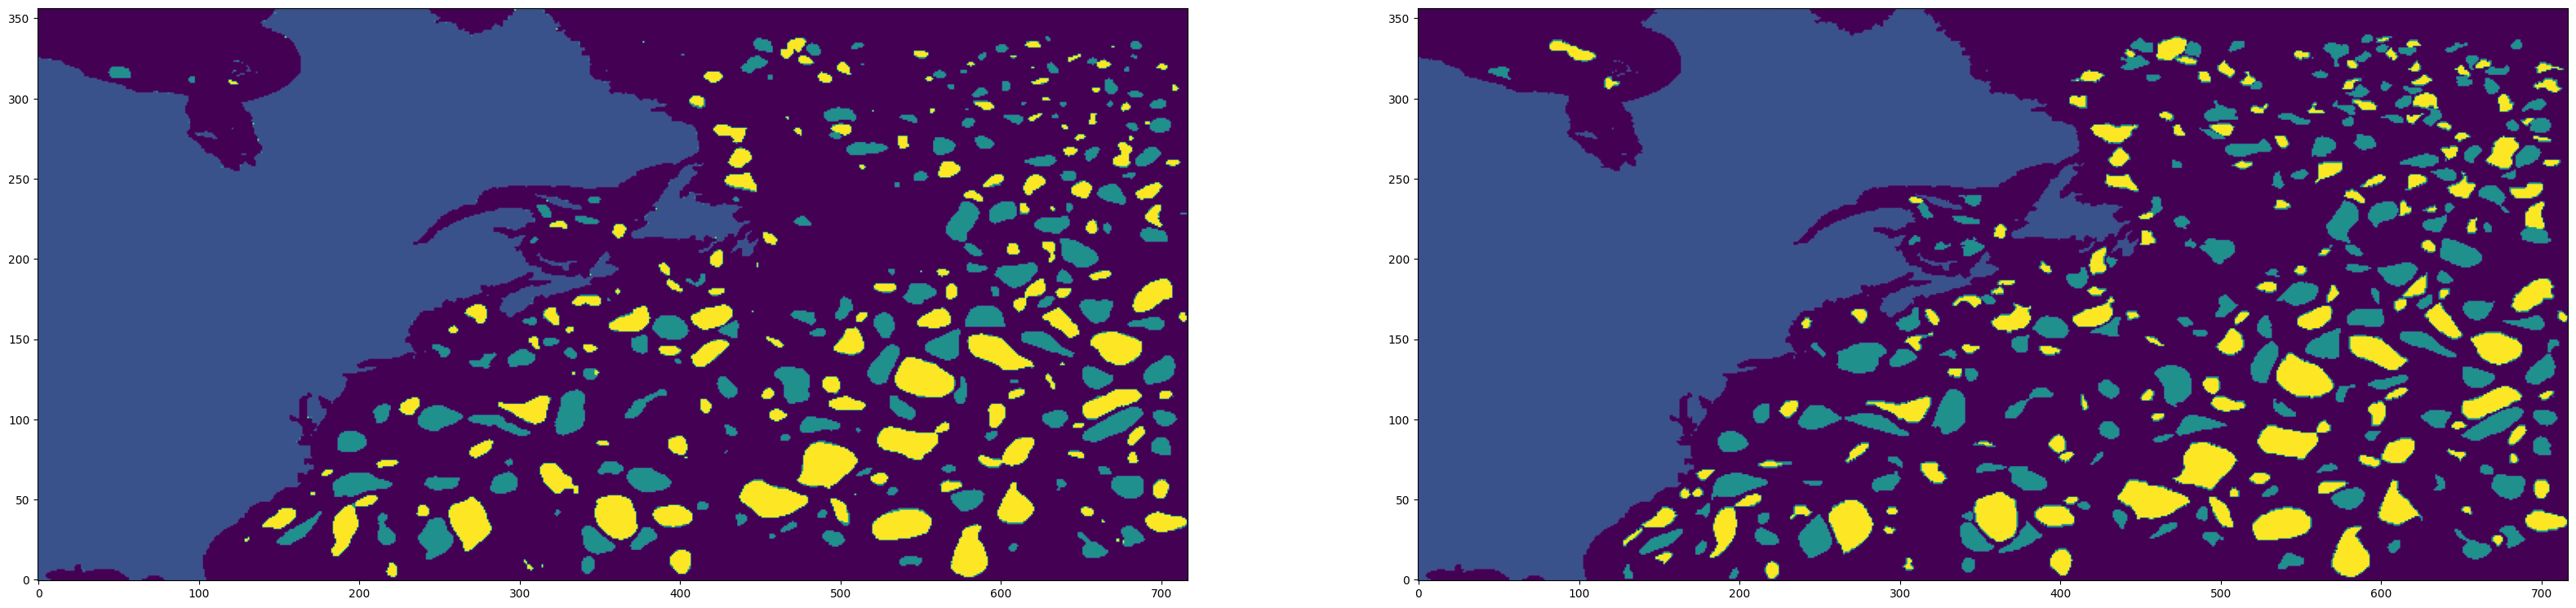

In [21]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_following_predicted=np.array(list_following_predicted)
#we don't want to saturate the image with the land(=999) so we set the land to 0.5
array_list_following_predicted=np.where(array_list_following_predicted>=100,0.5,array_list_following_predicted)
array_list_following_ground_truth=np.array(list_following_ground_truth)
array_list_following_ground_truth=np.where(array_list_following_ground_truth>=100,0.5,array_list_following_ground_truth)
fig, ax = plt.subplots(1, 2, figsize = (40, 32))
def init():
   
    ax[0].imshow(array_list_following_predicted[10][0],origin="lower")
    ax[1].imshow(array_list_following_ground_truth[10][0],origin="lower")
 
    return [ax]

def update(frame):
    ax[0].imshow(array_list_following_predicted[10][frame],origin="lower")
    ax[1].imshow(array_list_following_ground_truth[10][frame],origin="lower")

    return [ax]


animation = FuncAnimation(fig, update, frames=len(array_list_following_predicted[1]), init_func=init)

output_video = 'predicted_video_eddies_predict_vs_ground_truth.mp4'

animation.save(output_video, fps=1, extra_args=['-vcodec', 'libx264'])

### Attention ne pas supprimer cette cellule :

In [15]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_(gT_label, pred_label):

    
    gT_label = np.array(gT_label).flatten()
    pred_label = np.array(pred_label).flatten()
    cm = confusion_matrix(gT_label,pred_label,labels=[0,1,2],normalize='true')
    
    return cm





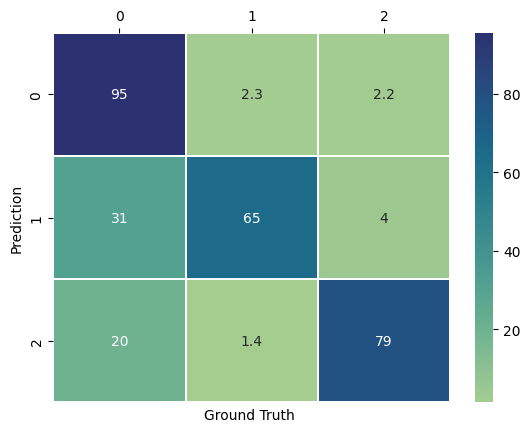

[[95.48226637  2.33263085  2.18510277]
 [31.06384662 64.94499918  3.9911542 ]
 [20.06595917  1.41593897 78.51810186]]


In [16]:
import seaborn
import matplotlib.pyplot as plt2
cm = confusion_matrix_(array_list_ground_truth,array_list_following_train)

ax = seaborn.heatmap(100*cm,annot=True, cmap="crest",linewidths=0.05)
ax.set(xlabel="Ground Truth ", ylabel="Prediction")
ax.xaxis.tick_top()
plt2.show()

print(100*cm)